# Forum Post Extraction

Sample: https://www.motor-talk.de/forum/start-probleme-audi-a6-c4-2-6-abc-t6820263.html?page=1

In [1]:
import spacy
import pandas as pd
from spacy.matcher import Matcher 
from spacy.pipeline import Sentencizer
from parts import collect, preprocessing, oie, domain_relevance

In [2]:
nlp = spacy.load("de_core_news_md")

In [3]:
### General SpaCy setup

sentencizer = Sentencizer(punct_chars=[".", "?", "!", ",", ";"])
nlp.add_pipe(sentencizer, name="sentence_segmenter", before="parser")

## Collecting

In [5]:
link = "https://www.motor-talk.de/forum/start-probleme-audi-a6-c4-2-6-abc-t6820263.html"

p = collect.get_text(link, "car")
print(len(p))

forum_text = " ; ".join(p)

105


## Preprocessing

In [6]:
# normalize lowercase = TRUE, remove_stopwords = FALSE
normalized = preprocessing.normalize(forum_text, 1, 0)

# clean no_questions = TRUE
cleaned = preprocessing.clean(normalized, 1)

In [7]:
with open("sentences.txt", 'w') as output:
    output.write(cleaned.replace("; ", "\n"))

## OIE

In [9]:
roots, terms, sents = oie.get_oie(cleaned)

terms2 = []
for sent in terms:
    terms2.append(", ".join(sent))

df = pd.DataFrame(roots, columns=["roots"])
df["terms"] = pd.DataFrame(terms2)
df["sents"] = pd.DataFrame(sents)

df.head(5)

,roots,terms,sents
0,hallo,hallo,hallo zusammen ;
1,machen,probleme,mein dicker macht seit kurzem probleme ;
2,probleme,"folgende probleme, probleme",folgende probleme ;
3,nicht starten,fahrzeug,fahrzeug startet nicht mehr ;
4,drehen,anlasser,anlasser dreht ;


## Domain Relevancy

In [40]:
with open("concepts.txt", "r") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
concepts = [x.strip() for x in content] 

In [48]:
domain_concepts = []  
for sent in terms:
    t = set()
    for term in sent:
        if term in concepts and term not in nlp.Defaults.stop_words:
             t.add(term)
    domain_concepts.append(t)

terms2 = []
for sent in domain_concepts:
    terms2.append(", ".join(sent))

df = pd.DataFrame(roots, columns=["roots"])
df["terms"] = pd.DataFrame(terms2)
df["sents"] = pd.DataFrame(sents)

df.head(50)

,roots,terms,sents
0,hallo,,hallo zusammen ;
1,machen,,mein dicker macht seit kurzem probleme ;
2,probleme,,folgende probleme ;
3,nicht starten,,fahrzeug startet nicht mehr ;
4,drehen,anlasser,anlasser dreht ;
5,probieren,,nach einiger zeit wieder probiert ;
6,starten,,fahrzeug startet normal ;
7,problem,,am nächsten tag gleiches problem wieder ;
8,fehlversuche,,also fehlversuche ;
9,können,,bisher konnte geprüft werden ;


## Evaluation

In [74]:
#df.to_csv("20200528_term-extraction.csv", index = False, header=True, sep = ';')

In [42]:
predicted = []
for sent in terms:
    p = 0
    for term in sent:
        if term in concepts:
            p = 1
    predicted.append(p)

In [43]:
df = pd.read_csv("resources/20200528_gold-standard-forumpost.csv", delimiter=";", names=["label","sent"])
df["predicted"] = pd.DataFrame(predicted)

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

In [45]:
confusion_matrix(df["label"], df["predicted"])

array([[50,  0],
       [35, 59]])

In [46]:
print(classification_report(df["label"], df["predicted"]))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        50
           1       1.00      0.63      0.77        94

    accuracy                           0.76       144
   macro avg       0.79      0.81      0.76       144
weighted avg       0.86      0.76      0.76       144



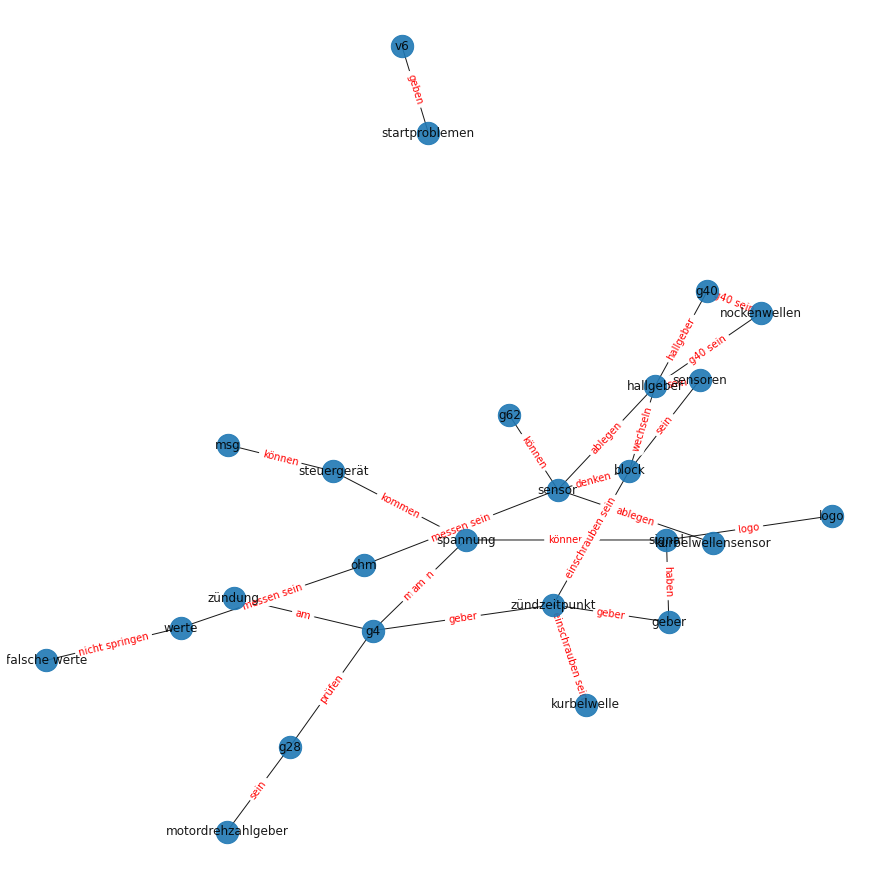

In [49]:
import networkx as nx 
import matplotlib.pyplot as plt 
%matplotlib inline

G = nx.Graph()
nodeA = []
nodeB = []
relation = []

for sent, root in zip(domain_concepts, roots):
    prev_term = 0
    for term in sent:
        if prev_term:
            G.add_edge(prev_term, term)
            nodeA.append(prev_term)
            nodeB.append(term)
            relation.append(root)
        else:
            prev_term = term
pos = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(figsize=(12,12))
nx.draw(G,pos,width=1,linewidths=1,node_size=500,alpha=0.9,labels={node:node for node in G.nodes()})
labels = dict(zip(list(zip(nodeA, nodeB)),relation))
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_color='red')

plt.axis('off')
plt.show()